![Main Image](http://www.isoldmyhouse.com/wp-content/uploads/2012/05/cheap-houses-for-sale-01.png)


# House Price Predict

## *Introduction*

#### 본 커널은 다른 분들이 올려주신 커널들을 참고하여 만들었습니다.
#### Regression tutorial을 진행하기 좋은 집값 예측 문제를 titanic처럼 초보자 분들에게 도움될 만한 커널을 만들고자 하였습니다.
#### 본 커널은 높은 점수, 등수를 얻기위함이 목적이 아닌 Baseline 수준의 튜토리얼 커널입니다. 
#### 초보자의 입장에서 초보자분들을 위해 커널을 작성하는 만큼, 쉽게 설명하고자 하였습니다. 
#### 저 또한 초보적인 실력이기 때문에 실수나 혹은 지적할만한 문제가 있다면 Feedback 해주시면 감사하겠습니다 ! 

### <a id='0'><strong>본 커널의 순서입니다.</strong></a>

#### 1.  <a href='#1'><strong>Import & Data Check</strong></a>
####      - 데이터 확인
####      - 이상치 탐색 및 제거
####      - 결측 데이터 확인 
####      - Skewness(비대칭도) 확인

#### 2.  <a href='#2'><strong>EDA</strong></a>   
####      - Numerical Data 탐색
####      - Categorical Data 탐색

#### 3.  <a href='#3'><strong>Feature Engineering</strong></a>
####      - Log 변환
####      - 결측 데이터 처리
####      - 유의하지 않은 변수 삭제
####      - Categorical Data 수치형 변환


#### 4.  <a href='#4'><strong>Modeling & make submission</strong></a>
####      - Model: XGBoost
####      - Submission

#### ***문제를 보기 전에 Data에 대한 이해를 한번 해보시는게 훨씬 쉽게 다가올 수 있습니다.***
#### ***Competition main에 가서 Data에 대한 설명을 읽고 오시면 도움이 많이 될 것입니다.***

# <a id='1'><strong>Import & Data check<strong></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
from collections import Counter

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


# 기본적 모듈을 임포트 해줍니다.

In [2]:
os.listdir("../input")

# input의 하위폴더를 확인해줍니다. 

['house-prices-advanced-regression-techniques']

In [3]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

# 트레인, 테스트 데이터를 불러옵니다.

In [4]:
df_train.head()

# 잘 불러졌는지 확인해봅니다.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_train.shape, df_test.shape

# train 데이터는 1460개의 데이터와 81개의 feature
# test 데이터는 1459개의 데이터와 80개의 feature가 있습니다.

((1460, 81), (1459, 80))

In [6]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

# 편의상 수치형 변수와 명목형 변수를 나눠줍니다.
# 수치형 변수는 38개, 명목형 변수는 43개가 있습니다.

Number of Numerical features:  38
Number of Categorical features:  43


In [7]:
print(df_train[numerical_feats].columns)
print("*"*80)
print(df_train[categorical_feats].columns)

# 변수명을 확인해봅니다. 

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
********************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual'

### - 이상치 탐색 및 제거

In [8]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = detect_outliers(df_train, 2, ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'])

# train 데이터의 이상치를 탐색합니다.
# IQR(튜키의 방법)을 이용한 함수를 지정하여 이상치 탐색을 수행합니다.

In [9]:
df_train.loc[Outliers_to_drop]

# 이상치가 발견된 행을 확인합니다.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
93,94,190,C (all),60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,133900
125,126,190,RM,60.0,6780,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,84500
165,166,190,RL,62.0,10106,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,127500
172,173,160,RL,44.0,5306,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,239000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,1351,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000
634,635,90,RL,64.0,6979,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,600,6,2010,WD,Normal,144000
910,911,90,RL,80.0,11600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,154300
1292,1293,70,RM,60.0,6600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,107500


In [10]:
df_train = df_train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
df_train.shape

# 이상치들을 제거해주고, 결과를 확인합니다.
# 행의 수가 1338로 줄어든것을 확인할 수 있습니다.

(1338, 81)

### - 결측치 확인

In [11]:
for col in df_train.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msperc)

# train 데이터 각 column의 결측치가 몇 %인지 확인합니다. 
# df_train[col].isnull().sum() : 해당 열의 결측치가 몇개인지 알 수 있게하는 문장입니다. (TRUE=1(결측치), FALSE=0으로 계산)
# df_train[col].shape[0] : 해당 열의 차원 (열이 지정되어 있으므로 행의 갯수를 보여줍니다.)
# 100 * (df_train[col].isnull().sum() / df_train[col].shape[0] : 위의 설명을 통해 %를 출력해주는 문장임을 알 수 있습니다.

column:         Id	 Percent of NaN value: 0.00%
column: MSSubClass	 Percent of NaN value: 0.00%
column:   MSZoning	 Percent of NaN value: 0.00%
column: LotFrontage	 Percent of NaN value: 17.12%
column:    LotArea	 Percent of NaN value: 0.00%
column:     Street	 Percent of NaN value: 0.00%
column:      Alley	 Percent of NaN value: 94.10%
column:   LotShape	 Percent of NaN value: 0.00%
column: LandContour	 Percent of NaN value: 0.00%
column:  Utilities	 Percent of NaN value: 0.00%
column:  LotConfig	 Percent of NaN value: 0.00%
column:  LandSlope	 Percent of NaN value: 0.00%
column: Neighborhood	 Percent of NaN value: 0.00%
column: Condition1	 Percent of NaN value: 0.00%
column: Condition2	 Percent of NaN value: 0.00%
column:   BldgType	 Percent of NaN value: 0.00%
column: HouseStyle	 Percent of NaN value: 0.00%
column: OverallQual	 Percent of NaN value: 0.00%
column: OverallCond	 Percent of NaN value: 0.00%
column:  YearBuilt	 Percent of NaN value: 0.00%
column: YearRemodAdd	 Percent of

In [12]:
for col in df_test.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msperc)

# test 데이터도 확인해줍니다.
# train, test 모두 PoolQc 데이터가 가장 결측치가 많습니다.

column:         Id	 Percent of NaN value: 0.00%
column: MSSubClass	 Percent of NaN value: 0.00%
column:   MSZoning	 Percent of NaN value: 0.27%
column: LotFrontage	 Percent of NaN value: 15.56%
column:    LotArea	 Percent of NaN value: 0.00%
column:     Street	 Percent of NaN value: 0.00%
column:      Alley	 Percent of NaN value: 92.67%
column:   LotShape	 Percent of NaN value: 0.00%
column: LandContour	 Percent of NaN value: 0.00%
column:  Utilities	 Percent of NaN value: 0.14%
column:  LotConfig	 Percent of NaN value: 0.00%
column:  LandSlope	 Percent of NaN value: 0.00%
column: Neighborhood	 Percent of NaN value: 0.00%
column: Condition1	 Percent of NaN value: 0.00%
column: Condition2	 Percent of NaN value: 0.00%
column:   BldgType	 Percent of NaN value: 0.00%
column: HouseStyle	 Percent of NaN value: 0.00%
column: OverallQual	 Percent of NaN value: 0.00%
column: OverallCond	 Percent of NaN value: 0.00%
column:  YearBuilt	 Percent of NaN value: 0.00%
column: YearRemodAdd	 Percent of

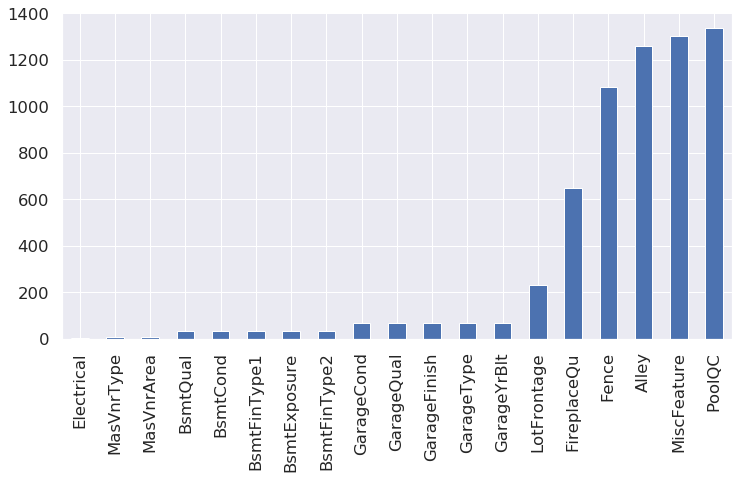

In [13]:
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize = (12,6))

# 직관적으로 확인하기 위해 barplot을 그려봅니다.

### - Skewness (비대칭도) 확인

In [14]:
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )
    
# 수치형 변수의 Skewness(비대칭도), Kurtosis(첨도)를 확인합니다.
# 이는 분포가 얼마나 비대칭을 띄는가 알려주는 척도입니다. (비대칭도: a=0이면 정규분포, a<0 이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침)
# 비대칭도와 첨도를 띄는 변수가 여럿 보입니다. Target Feature인 "SalePrice" 또한 약간의 정도를 보이는 것으로 보입니다.

Id              Skewness: 00.00     Kurtosis: -01.19
MSSubClass      Skewness: 01.37     Kurtosis: 001.49
LotFrontage     Skewness: 01.59     Kurtosis: 013.04
LotArea         Skewness: 07.78     Kurtosis: 123.55
OverallQual     Skewness: 00.16     Kurtosis: -00.05
OverallCond     Skewness: 00.74     Kurtosis: 001.23
YearBuilt       Skewness: -0.58     Kurtosis: -00.60
YearRemodAdd    Skewness: -0.52     Kurtosis: -01.27
MasVnrArea      Skewness: 02.69     Kurtosis: 011.04
BsmtFinSF1      Skewness: 00.65     Kurtosis: -00.50
BsmtFinSF2      Skewness: 04.86     Kurtosis: 026.86
BsmtUnfSF       Skewness: 00.87     Kurtosis: 000.29
TotalBsmtSF     Skewness: 00.29     Kurtosis: 001.17
1stFlrSF        Skewness: 00.66     Kurtosis: 000.02
2ndFlrSF        Skewness: 00.77     Kurtosis: -00.80
LowQualFinSF    Skewness: 12.74     Kurtosis: 170.50
GrLivArea       Skewness: 00.66     Kurtosis: 000.54
BsmtFullBath    Skewness: 00.56     Kurtosis: -00.96
BsmtHalfBath    Skewness: 04.91     Kurtosis: 

# <a id='2'><strong>EDA</strong></a>

### - Numerical Data 탐색

#### 수치형 데이터들을 알아보기 위해 다음 4가지의 Plot을 그립니다.
* Correlation Heat Map
* Zoomed Heat Map
* Pair Plot
* Scatter Plot

#### Correlation Heat Map

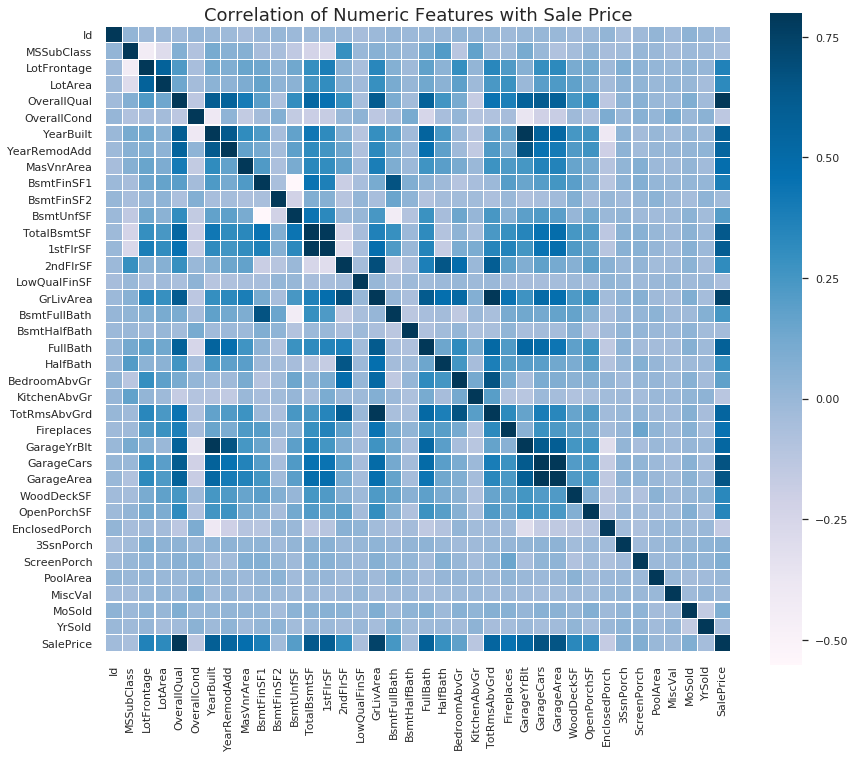

In [15]:
corr_data = df_train[['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
                      'MiscVal', 'MoSold', 'YrSold', 'SalePrice']]

colormap = plt.cm.PuBu
sns.set(font_scale=1.0)

f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features with Sale Price',y=1,size=18)
sns.heatmap(corr_data.corr(),square = True, linewidths = 0.1,
            cmap = colormap, linecolor = "white", vmax=0.8)

# Heat Map은 seaborn 덕분에 직관적으로 이해가 가능하여 변수 간 상관관계에 대하여 쉽게 알 수 있습니다.
# 또한 변수 간 다중 공선성을 감지하는 데 유용합니다.
# 대각선 열을 제외한 박스 중 가장 진한 파란색을 띄는 박스가 보입니다.
# 첫 번째는 'TotalBsmtSF'와 '1stFlrSF'변수의 관계입니다.
# 두 번째는 'Garage'와 관련한 변수를 나타냅니다. 
# 두 경우 모두 변수 사이의 상관 관계가 너무 강하여 다중 공선성(MultiColarisity) 상황이 나타날 수 있습니다. 
# 변수가 거의 동일한 정보를 제공하므로 다중 공선성이 실제로 발생한다는 결론을 내릴 수 있습니다.
# 또한 확인해야할 부분은 'SalePrice'와의 상관 관계입니다. 
# 'GrLivArea', 'TotalBsmtSF'및 'OverallQual'은 큰 관계를 보입니다. 
# 나머지 변수와의 상관 관계를 자세히 알아보기 위해 Zoomed Heat Map을 확인합니다.

#### Zoomed Heat Map

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'FullBath', 'TotRmsAbvGrd',
       'YearRemodAdd'],
      dtype='object')


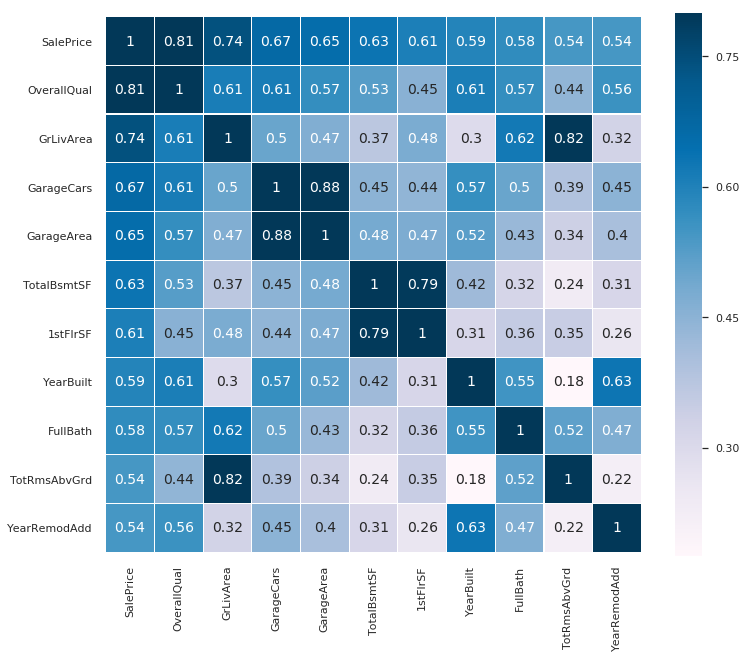

In [16]:
k= 11
cols = corr_data.corr().nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(df_train[cols].values.T)
f , ax = plt.subplots(figsize = (12,10))
sns.heatmap(cm, vmax=.8, linewidths=0.1,square=True,annot=True,cmap=colormap,
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':14},yticklabels = cols.values)

# 가장 눈에 띄는 GarageCars와 GarageArea, TotalBsmtSF와 1stFlrSF는 서로 밀접하게 연관되어 있음을 알 수 있습니다.
# Target feature와 가장 밀접한 연관이 있는 feature는 'OverallQual', 'GrLivArea'및 'TotalBsmtSF'로 보입니다.
# 먼저 말했던 GarageCars와 GarageArea, TotalBsmtSF와 1stFlrSF, TotRmsAbvGrd와 GrLivArea는 모두 매우 유사한 정보를 포함하고 있으며 다중공선성이 나타난다고 할 수 있습니다. 
# SalePrice와 더 연관되어있는 변수인 GarageCars와 TotalBsmtSF, GrLivArea를 남기고 나머지는 이후에 버리도록 합니다.
# SalePrice와의 연관을 더 알아보기 위해 PairPlot을 그려보도록 합니다.

#### Pair Plot

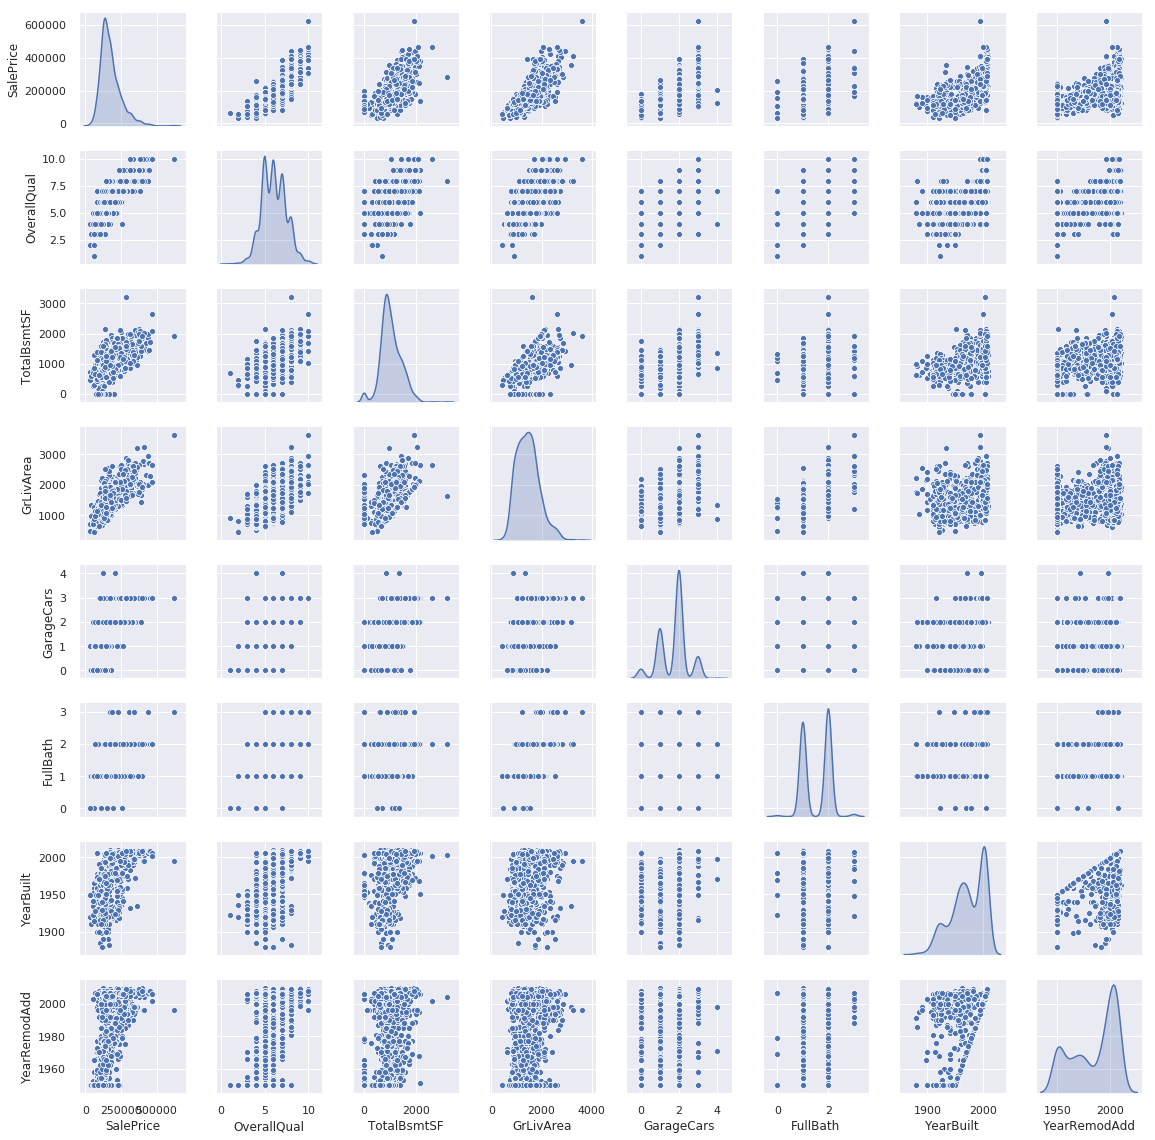

In [17]:
sns.set()
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(df_train[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

# 위의 Zoomed Heat Map에서 다중공선성을 보이는 변수 중 SalePrice와 연관이 덜 한 변수를 제외하고 PairPlot을 그립니다.
# 'TotalBsmtSF'와 'GrLiveArea'는 데이터 설명에서 알 수 있듯이 지하실의 면적과 생활공간 면적을 의미합니다.
# 'TotalBsmtSF'와 'GrLiveArea'의 plot을 보면 점들이 직선처럼 그려지고 대부분의 점은 해당 선 아래에 유지됩니다. 
# 이것은 일반적으로 지하실 면적이 지상 생활 면적과 같을 수 있지만, 더 크진 않기 때문에 보여지는 특징이라고 할 수 있습니다.
# 'SalePrice'와 'YearBuilt'의 plot을 보면 우상향 곡선을 보입니다.
# 이것은 전년도 대비 주택 가격 상승의 가속을 의미한다고 할 수 있습니다.

#### Scatter Plot

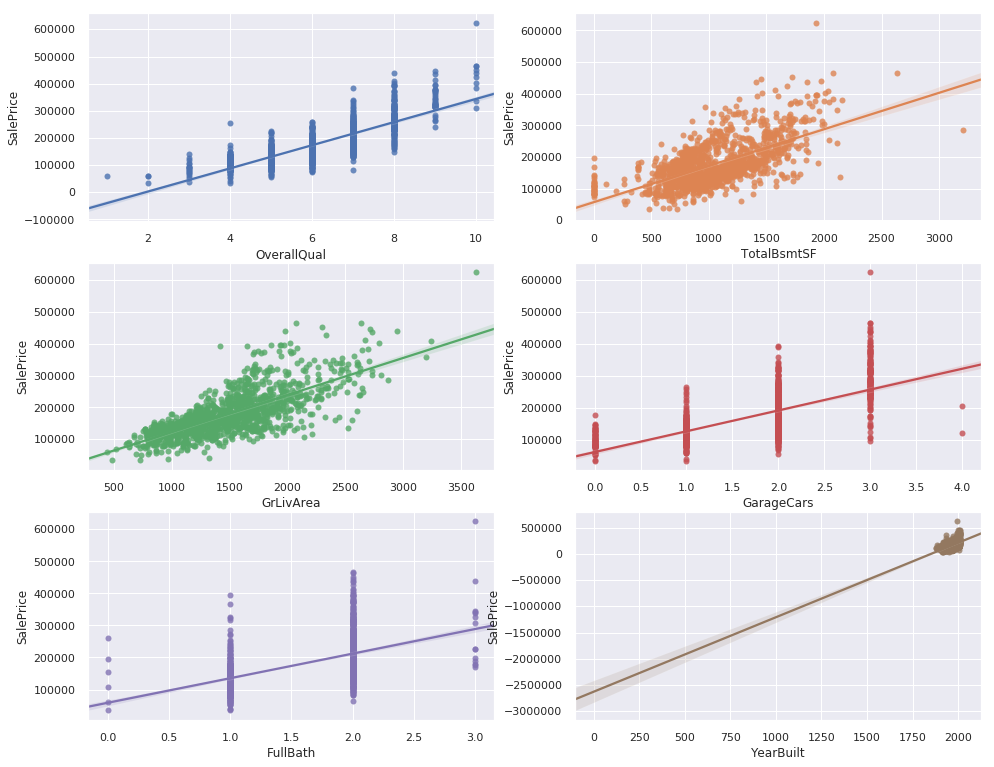

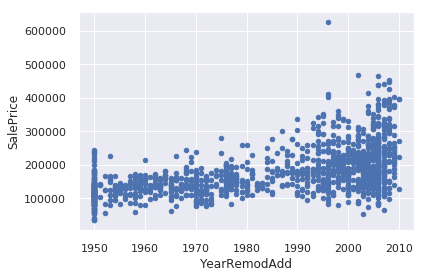

In [18]:
fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(16,13))
OverallQual_scatter_plot = pd.concat([df_train['SalePrice'],df_train['OverallQual']],axis = 1)
sns.regplot(x='OverallQual',y = 'SalePrice',data = OverallQual_scatter_plot,scatter= True, fit_reg=True, ax=ax1)
TotalBsmtSF_scatter_plot = pd.concat([df_train['SalePrice'],df_train['TotalBsmtSF']],axis = 1)
sns.regplot(x='TotalBsmtSF',y = 'SalePrice',data = TotalBsmtSF_scatter_plot,scatter= True, fit_reg=True, ax=ax2)
GrLivArea_scatter_plot = pd.concat([df_train['SalePrice'],df_train['GrLivArea']],axis = 1)
sns.regplot(x='GrLivArea',y = 'SalePrice',data = GrLivArea_scatter_plot,scatter= True, fit_reg=True, ax=ax3)
GarageCars_scatter_plot = pd.concat([df_train['SalePrice'],df_train['GarageCars']],axis = 1)
sns.regplot(x='GarageCars',y = 'SalePrice',data = GarageCars_scatter_plot,scatter= True, fit_reg=True, ax=ax4)
FullBath_scatter_plot = pd.concat([df_train['SalePrice'],df_train['FullBath']],axis = 1)
sns.regplot(x='FullBath',y = 'SalePrice',data = FullBath_scatter_plot,scatter= True, fit_reg=True, ax=ax5)
YearBuilt_scatter_plot = pd.concat([df_train['SalePrice'],df_train['YearBuilt']],axis = 1)
sns.regplot(x='YearBuilt',y = 'SalePrice',data = YearBuilt_scatter_plot,scatter= True, fit_reg=True, ax=ax6)
YearRemodAdd_scatter_plot = pd.concat([df_train['SalePrice'],df_train['YearRemodAdd']],axis = 1)
YearRemodAdd_scatter_plot.plot.scatter('YearRemodAdd','SalePrice')

# Target Feature "SalePrice"와 가장 밀접한 연관이 있다고 판단됐던 변수들의 Scatter Plot을 그립니다.
# OverallQual, GarageCars, Fullbath와 같은 변수들은 실제로는 범주형 데이터의 특징을 보인다고 할 수 있습니다. (등급, 갯수 등을 의미하기 때문)

### - Categorical Data 탐색

#### 남은 범주형 변수들도 확인해봅니다. 
#### 질적 변수를 사용하여 두 가지 방법을 구현할 수 있습니다. 
#### 첫 번째는 변수 값과 관련하여 SalePrice의 분포를 확인합니다.
#### 두 번째로 가능한 범주별로 더미 변수를 만듭니다.

In [19]:
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('#'*50)
    
# 범주형 변수들과 각 범주들을 확인합니다.

RL         1055
RM          197
FV           65
RH           14
C (all)       7
Name: MSZoning, dtype: int64
##################################################
Pave    1335
Grvl       3
Name: Street, dtype: int64
##################################################
Grvl    42
Pave    37
Name: Alley, dtype: int64
##################################################
Reg    859
IR1    440
IR2     32
IR3      7
Name: LotShape, dtype: int64
##################################################
Lvl    1211
Bnk      52
HLS      48
Low      27
Name: LandContour, dtype: int64
##################################################
AllPub    1338
Name: Utilities, dtype: int64
##################################################
Inside     972
Corner     235
CulDSac     81
FR2         46
FR3          4
Name: LotConfig, dtype: int64
##################################################
Gtl    1275
Mod      56
Sev       7
Name: LandSlope, dtype: int64
##################################################
NAmes      20

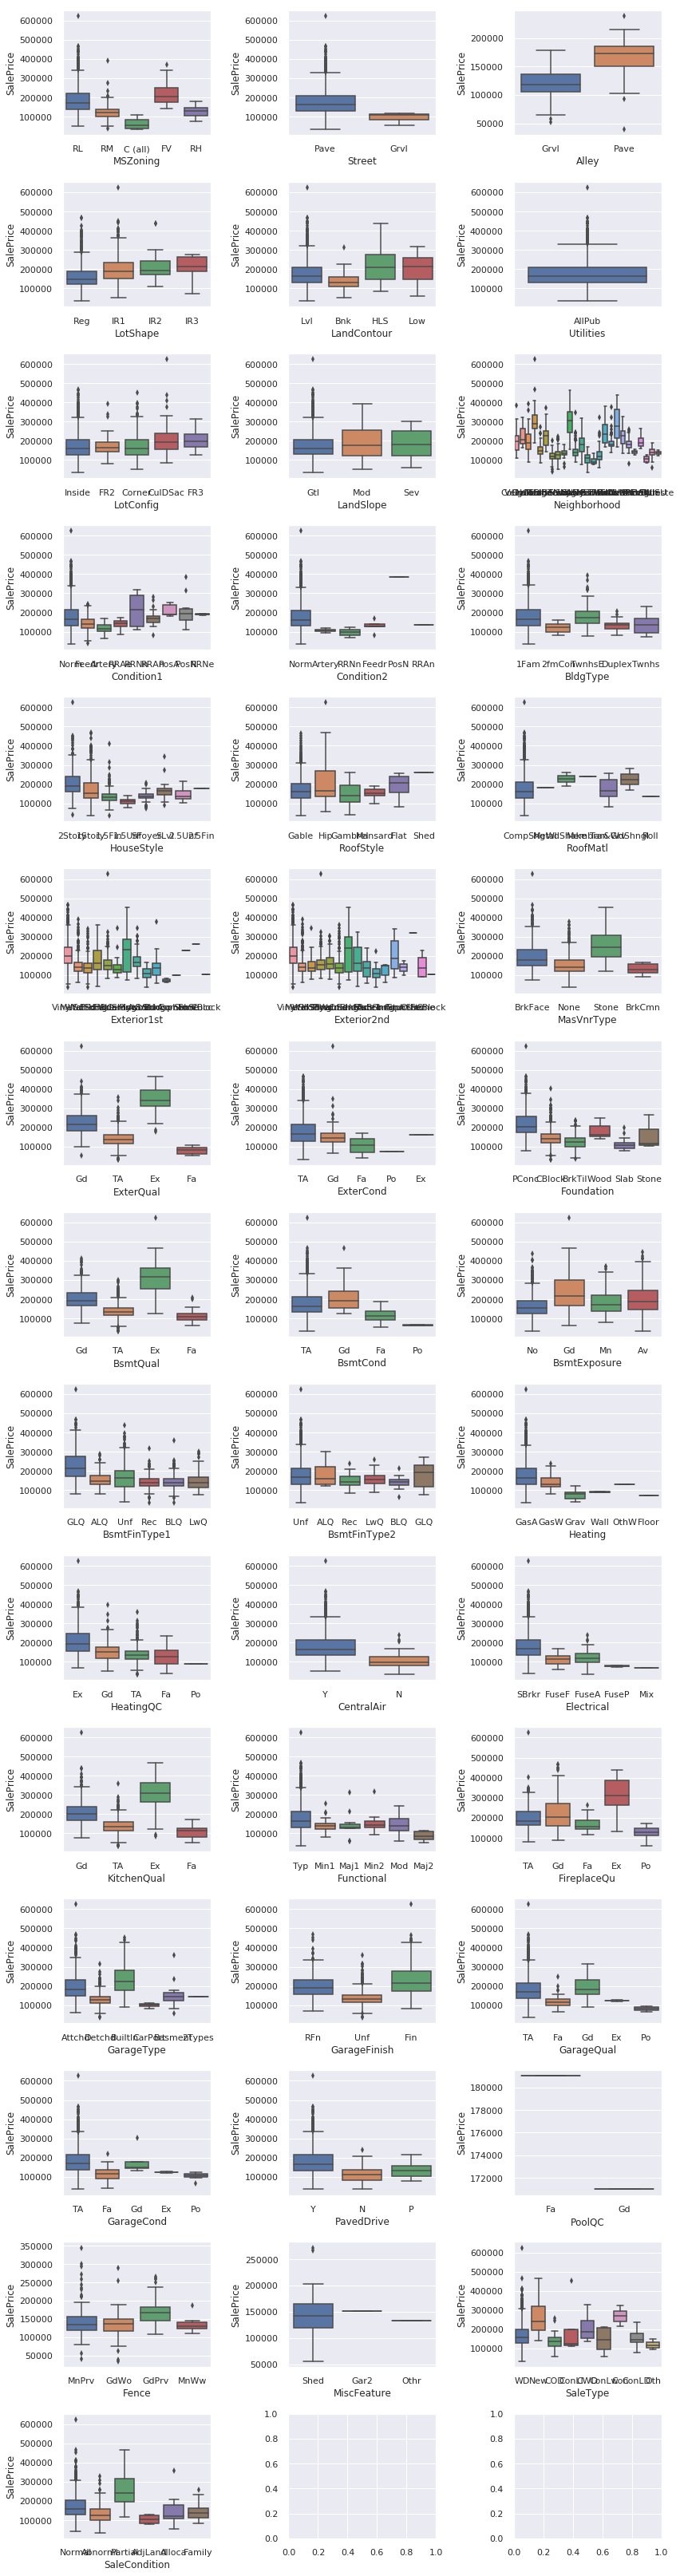

In [20]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=df_train["SalePrice"], data=df_train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()

# BoxPlot을 그려 Categorical Feature와 SalePrice의 관계를 확인합니다.
# 일부 범주는 다른 범주보다 SalePrice와 관련하여 더 다양하게 보입니다. 
# Neighborhood 변수는 주택 가격 편차가 매우 크므로 영향이 크다고 생각됩니다.
# SaleType 또한 마찬가지입니다.
# 또한 수영장이 있으면 가격이 크게 증가하는 것 같습니다.
# 정리하면 SalePrice에 영향을 많이 끼치는 변수로는 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual', 'CentralAir', 'Electrical', 'KitchenQual', 'SaleType' 등이 있습니다.

In [21]:
num_strong_corr = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars',
                   'FullBath','YearBuilt','YearRemodAdd']

num_weak_corr = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

catg_strong_corr = ['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',
                    'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

# 편의를 위해 SalePrice와 관련이 큰 변수와 아닌 변수를 분리해놓습니다.
# "Id"는 submission 때문에 따로 빼놓겠습니다.

# <a id='3'><strong>Feature Engineering</strong></a>

### - Log 변환 

Skewness: 1.287364
Kurtosis: 2.555029


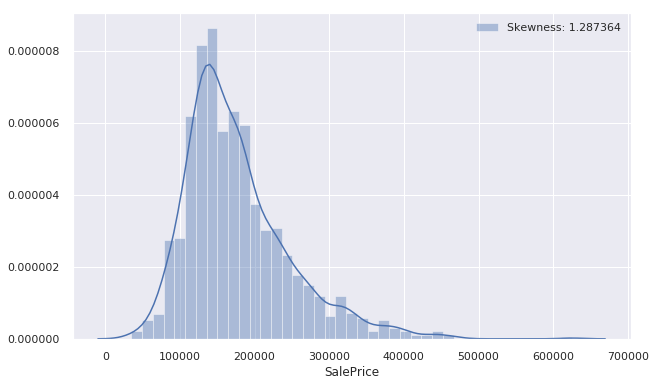

In [22]:
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["SalePrice"], color = "b", label="Skewness: {:2f}".format(df_train["SalePrice"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % df_train["SalePrice"].skew())
print("Kurtosis: %f" % df_train["SalePrice"].kurt())

# Target Feature인 SalePrice의 비대칭도와 첨도를 확인합니다. 
# 그래프와 수치를 확인하면 정상적으로 분포되지 않는것을 확인할 수 있습니다. 
# 예측의 정확도를 높히기 위해 로그 변환을 수행합니다.

Skewness: -0.032026
Kurtosis: 0.571897


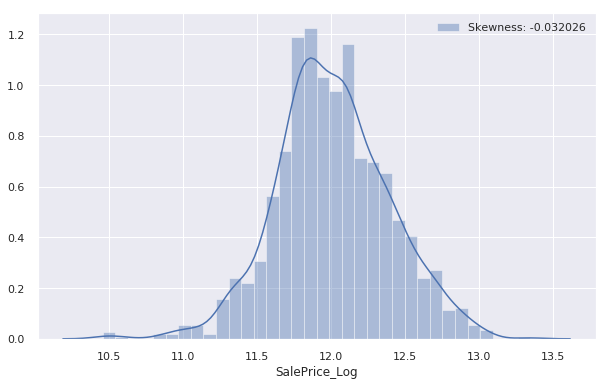

In [23]:
df_train["SalePrice_Log"] = df_train["SalePrice"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["SalePrice_Log"], color = "b", label="Skewness: {:2f}".format(df_train["SalePrice_Log"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())

df_train.drop('SalePrice', axis= 1, inplace=True)

# kewness, Kurtosis를 없애주기 위해 로그를 취해줍니다.
# Log변환을 수행한 새로운 feature "SalePrice_Log"를 만들고 전 Feature인 "Saleprice"를 버려줍니다.
# 로그를 취해준 그래프와 수치가 바뀐 모습을 볼 수 있습니다. (정규근사화)

#### Data Check 과정에서 살펴봤을 때 Skewness와 Kurtosis가 보이는 변수들이 꽤 있었습니다.
#### 하지만 EDA 과정에서 중요하다고 판단되었던 Numerical feature들은 Skewness와 Kurtosis가 수치적으로 보이지 않으므로 Target Feature인 SalePrice만 Log를 취해줍니다.

### - 결측 데이터 처리

#### 집값 예측 문제에는 굉장히 많은 NaN 데이터가 포함되어있습니다. 
#### 하지만 여러 변수들의 특징을 잘 살펴보면 NaN의 의미를 재파악할 수 있습니다.
#### 단지 있다, 없다 개념일뿐 측정되지 않은 데이터의 의미가 아닙니다.
#### 이러한 변수들의 특징을 잘 파악하여 결측 데이터를 처리해주도록 합니다.

In [24]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)
    
# 위에서 설명한 바와 같이 '없다'의 의미를 갖는 변수들입니다.
# NaN을 없다는 의미의 None으로 대체해줍니다.

In [25]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

# 결측치의 처리 정도를 확인해 줍니다.

,Total,Percent
LotFrontage,229,0.171151
GarageYrBlt,65,0.048580
MasVnrArea,7,0.005232
SalePrice_Log,0,0.000000
ExterCond,0,0.000000


In [26]:
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

# 나머지 결측치들은 평균값으로 대체하겠습니다.

In [27]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

# 다시 확인해보면 결측치가 사라진 것을 알 수 있습니다.

,Total,Percent
SalePrice_Log,0,0.0
Heating,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0


In [28]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

### - 유의하지 않은 변수 삭제

In [29]:
id_test = df_test['Id']

to_drop_num  = num_weak_corr
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)
    
# SalePrice와의 상관관계가 약한 모든 변수를 삭제합니다.

In [30]:
df_train.head()

# 삭제가 잘 진행되었는지 확인합니다.

,MSZoning,Neighborhood,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,Electrical,GrLivArea,FullBath,KitchenQual,GarageCars,SaleType,SalePrice_Log
0,RL,CollgCr,Norm,7,2003,2003,BrkFace,Gd,Gd,856,Y,SBrkr,1710,2,Gd,2,WD,12.247694
1,RL,Veenker,Norm,6,1976,1976,None,TA,Gd,1262,Y,SBrkr,1262,2,TA,2,WD,12.109011
2,RL,CollgCr,Norm,7,2001,2002,BrkFace,Gd,Gd,920,Y,SBrkr,1786,2,Gd,2,WD,12.317167
3,RL,Crawfor,Norm,7,1915,1970,None,TA,TA,756,Y,SBrkr,1717,1,Gd,3,WD,11.849398
4,RL,NoRidge,Norm,8,2000,2000,BrkFace,Gd,Gd,1145,Y,SBrkr,2198,2,Gd,3,WD,12.429216


### - Categorical Data 수치형 변환

#### EDA과정의 Boxplot에서 보았던 SalePrice에 영향이 큰 변수들을 변환해줍니다.
#### 먼저 ViolinPlot을 그려 각 범주들과 SalePrice의 관계를 살펴봅니다.

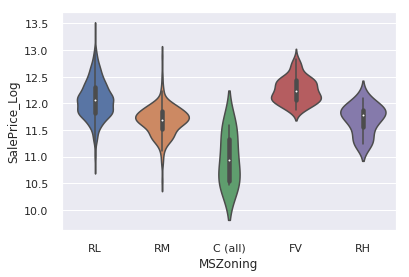

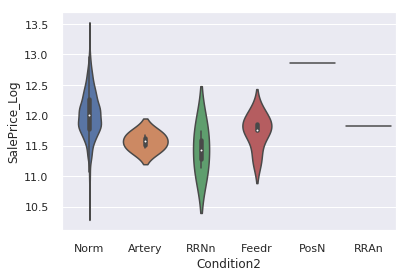

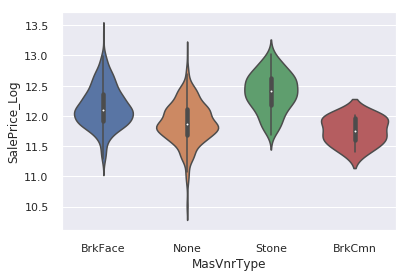

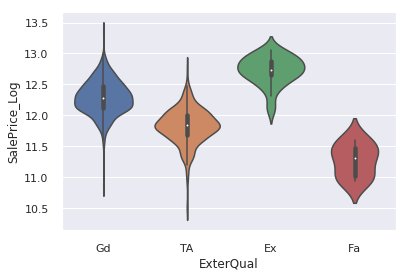

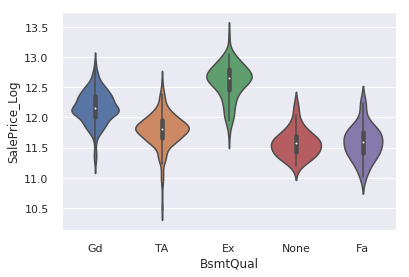

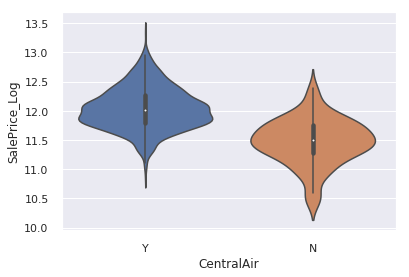

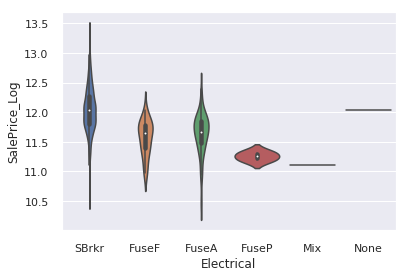

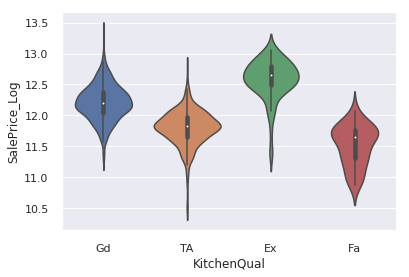

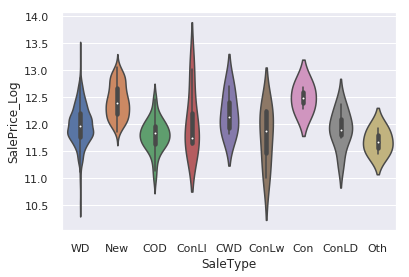

In [31]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list :
    sns.violinplot(x=catg, y=df_train["SalePrice_Log"], data=df_train)
    plt.show()
    
# 각 범주들을 개별로 살펴봅니다.

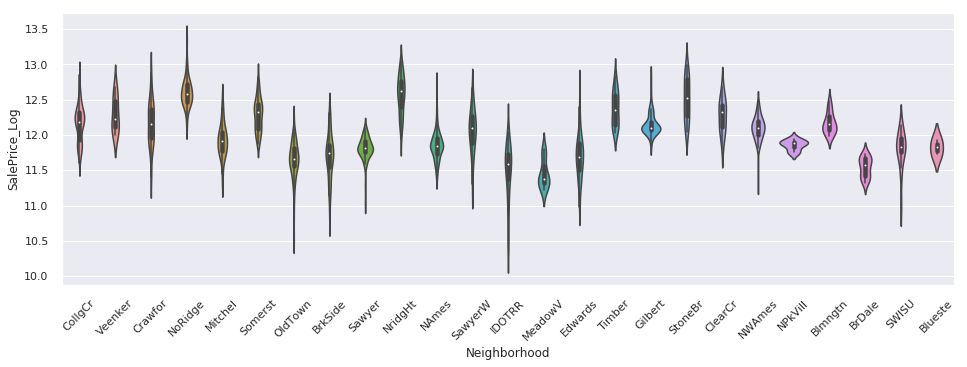

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='Neighborhood', y=df_train["SalePrice_Log"], data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

# 범주가 가장 많은 Neighborhood 변수도 살펴봅니다.

In [33]:
for catg in catg_list :
    g = df_train.groupby(catg)["SalePrice_Log"].mean()
    print(g)
    
# 각 범주들에 해당되는 SalePrice_Log 평균을 살펴봅니다.  

MSZoning
C (all)    10.960733
FV         12.246616
RH         11.700602
RL         12.069474
RM         11.677434
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.734675
Norm      12.012766
PosN      12.860999
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.757397
BrkFace    12.150038
None       11.884715
Stone      12.391766
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.727937
Fa    11.274881
Gd    12.295102
TA    11.828332
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.595497
Fa      11.585725
Gd      12.170320
None    11.572903
TA      11.791989
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.471479
Y    12.042717
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.641350
FuseF    11.565700
FuseP    11.256345
Mix      11.112448
None     12.028739
SBrkr    12.047595
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.582467
Fa    11.514567
Gd    12.209558
TA    11.

In [34]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

# 수치형 변환을 위해 Violinplot과 SalePrice_Log 평균을 참고하여 각 변수들의 범주들을 그룹화 합니다.

In [35]:
for df in [df_train, df_test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4 
    
# 각 범주별로 수치형 변환을 실행합니다.

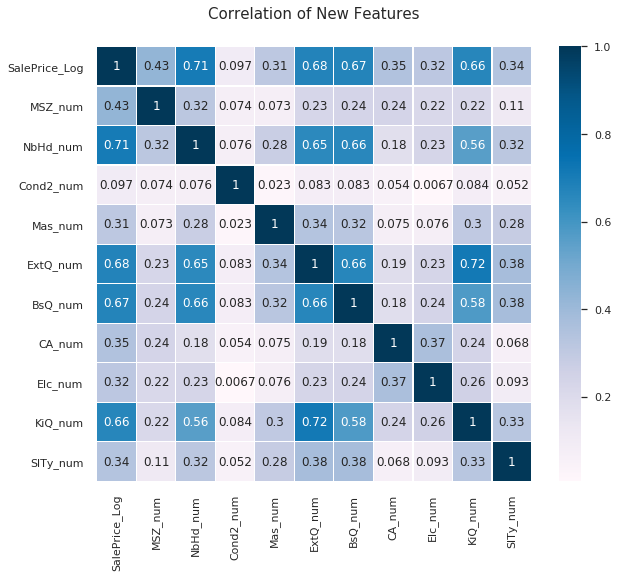

In [36]:
new_col_HM = df_train[['SalePrice_Log', 'MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']]

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Correlation of New Features", y = 1.05, size = 15)
sns.heatmap(new_col_HM.corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 12})

# 변환하여 새로 만들어진 numerical feature들 또한 Heat Map을 그려봅니다.
# NbHd_num, ExtQ_num, BsQ_num, KiQ_num를 제외하고는 SalePrice_Log와 큰 상관관계가있는 열은 거의 없습니다.

In [37]:
df_train.drop(['MSZoning','Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis = 1, inplace = True)
df_test.drop(['MSZoning', 'Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis = 1, inplace = True)

# 기존 범주형 변수와 새로 만들어진 수치형 변수 역시 유의하지 않은 것들은 삭제합니다. 

In [38]:
df_train.head()

# 완벽히 삭제되어 유의하다고 판단되는 수치형 변수만 남았습니다.

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,SalePrice_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,7,2003,2003,856,1710,2,2,12.247694,3,2,3,2,3
1,6,1976,1976,1262,1262,2,2,12.109011,3,2,2,2,2
2,7,2001,2002,920,1786,2,2,12.317167,3,2,3,2,3
3,7,1915,1970,756,1717,1,3,11.849398,3,2,2,1,3
4,8,2000,2000,1145,2198,2,3,12.429216,3,3,3,2,3


In [39]:
df_test.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,5,1961,1961,882.0,896,1,1.0,2,1,2,1,2
1,6,1958,1958,1329.0,1329,1,1.0,3,1,2,1,3
2,5,1997,1998,928.0,1629,2,2.0,3,2,2,2,2
3,6,1998,1998,926.0,1604,2,2.0,3,2,2,1,3
4,8,1992,1992,1280.0,1280,2,2.0,3,3,3,2,3


# <a id='4'><strong>Modeling & make submission</strong></a>

### Model: XGBoost

#### XGBoost를 사용하여 예측하겠습니다. 
#### 튜토리얼이 목적인 커널이므로 간단하게 모델링하여 결과를 확인합니다.
#### 다른 모델을 사용하고 싶으시거나 성능을 높혀 결과값을 더 좋게 받고싶으신 분들은 상위커널들을 참고하시면 될 것 같습니다!

In [40]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train = df_train.drop("SalePrice_Log", axis = 1).values
target_label = df_train["SalePrice_Log"].values
X_test = df_test.values
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.2, random_state = 2000)

# Test하기 전 Validation 과정을 겨처줍니다.
# train데이터의 20%를 validation으로 주고 80%을 train으로 남겨주어 분리해줍니다.

In [41]:
import xgboost
regressor = xgboost.XGBRegressor(colsample_bytree = 0.4603, learning_rate = 0.06, min_child_weight = 1.8,
                                 max_depth= 3, subsample = 0.52, n_estimators = 2000,
                                 random_state= 7, ntrhead = -1)
regressor.fit(X_tr,y_tr)

# XGBoost 모델을 만들어줍니다.

[19:51:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0,
             importance_type='gain', learning_rate=0.06, max_delta_step=0,
             max_depth=3, min_child_weight=1.8, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, ntrhead=-1, objective='reg:linear',
             random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.52, verbosity=1)

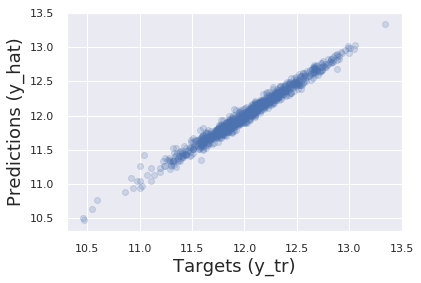

In [42]:
y_hat = regressor.predict(X_tr)

plt.scatter(y_tr, y_hat, alpha = 0.2)
plt.xlabel('Targets (y_tr)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

# 예측 된 y 값 (y_hat)에 대한 Scatter Plot을 그려봅니다.

In [43]:
regressor.score(X_tr,y_tr)

0.9778929954593789

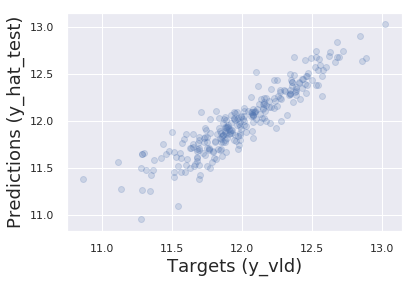

In [44]:
y_hat_test = regressor.predict(X_vld)


plt.scatter(y_vld, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_vld)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.show()

# validation으로 예측해봅니다.

In [45]:
regressor.score(X_vld,y_vld)

0.8387039163837681

In [46]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressor, X = X_tr, y = y_tr, cv = 10)

# k-fold validation을 수행합니다.

[19:51:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [47]:
print(accuracies.mean())
print(accuracies.std())

# 정확도를 확인해봅니다.

0.8463773269333027
0.03393380365418177


### - Submission

In [48]:
use_logvals = 1

pred_xgb = regressor.predict(X_test)

sub_xgb = pd.DataFrame()
sub_xgb['Id'] = id_test
sub_xgb['SalePrice'] = pred_xgb

if use_logvals == 1:
    sub_xgb['SalePrice'] = np.exp(sub_xgb['SalePrice']) 

sub_xgb.to_csv('xgb.csv',index=False)

# use_logvals는 Log를 취해준 Target feature을 exp해주기 위해 사용되는 스위치 역할입니다.
# 제대로 된 예측을 위해 학습 후 Log변환을 풀어줘야하기 때문입니다.
# 이 셀의 코드를 통해 submission까지 완료하게됩니다.

### 이렇게 해서 House Price Predict의 Tutorial을 진행해 보았습니다.
#### 부족하지만 저와 같이 헤매는 많은 초보자 분들에게 도움이 되었으면 합니다.
#### 지적, 고쳐야할 점 등 Feedback 환영입니다!
#### 조금이나마 도움이 되셨다면 upvote 부탁드립니다 감사합니다 :)